# The goal of this project is to make PubMed abstracts easier to read. Based on the work in https://arxiv.org/abs/1710.06071 #

Each sentence of an abstract is going to be categorized into one of five different classes:
* Background
* Objective
* Methods
* Results
* Conclusion

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import OneHotEncoder

## Get the data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 20.05 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
pubmed-rct  sample_data


## Preprocessing function to read the data


In [3]:
def read_data(path):
  '''
  path: one of "dev", "test", "train"

  Returns:
    List of dictionaries of the form {'label' (string): <one of 5 categories>,
                                      'text' (string): <text of one line of abstract>
                                      'position' (int): <position of this line of text in given abstract category>
                                      'num_lines' (int): <total # of sentences in given abstract category>}
    - sentences: list of sentences in a given file
    - labels: list of labels of each sentence
  '''
  data = []
  # Smaller set od data (20k abstracts) will be used
  path = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign' + '/' + path + '.txt'

  with open(path) as file:
    for line in file:
      # If line starts wit ### new abstract begins
      if line.startswith('###'):
        # Reset position variable
        pos = 0
      # Abstract ends
      elif line == '\n':
        # Add info about total number of lines in given abstract
        for i in range(1, pos + 1):
          data[-i]['num_lines'] = pos - 1
      else:
        line_splited = line.split('\t')
        label = line_splited[0]
        text = line_splited[1].replace(" .", "").replace(" ,", "").strip()
        # Append dictionary to the data
        data.append({'label': label,
                     'text': text,
                     'pos': pos})
        pos += 1


    return data

## Load the data

In [4]:
train_data = read_data('train')
test_data = read_data('test')
validation_data = read_data('dev')


In [5]:
train_data[11]

{'label': 'CONCLUSIONS',
 'text': 'Low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain better physical function and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ )',
 'pos': 11,
 'num_lines': 11}

## Create DataFrames for train, val and test data

In [6]:
train_data_df = pd.DataFrame(train_data)
test_data_df = pd.DataFrame(test_data)
validation_data_df = pd.DataFrame(validation_data)

train_data_df.head()

,label,text,pos,num_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


### Check out distribution of labels in training data



<Axes: >

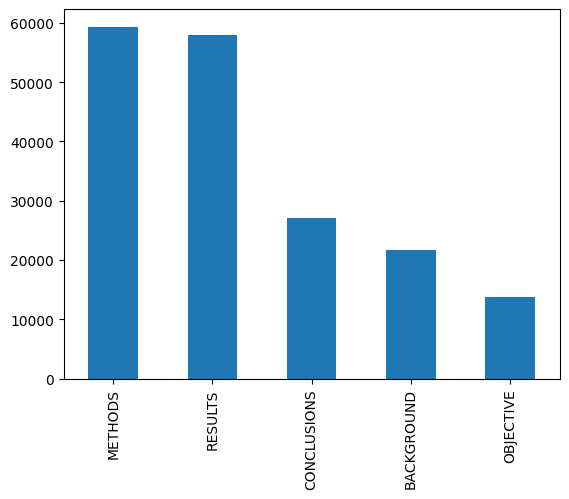

In [7]:
train_data_df['label'].value_counts().plot.bar()

## One-hot-encoding of labels

In [8]:
encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = encoder.fit_transform(train_data_df['label'].to_numpy().reshape(-1, 1))
test_labels_one_hot = encoder.transform(test_data_df['label'].to_numpy().reshape(-1, 1))
validation_labels_one_hot = encoder.transform(validation_data_df['label'].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Define constants for Text Vectorization layers

In [9]:
# Calculate average sentence length (to set max sequence length in Text Vectorization layer)
sentences = train_data_df['text']
sentences_lengths = [len(sentence.split()) for sentence in sentences]
mean_sentence_length = np.mean(sentences_lengths)
print(mean_sentence_length)

# Mean sentence length = 24. Let's find out what is the 95th percentile of sentence lengths
length_95_perc = np.percentile(sentences_lengths, 95)
print(length_95_perc)

# Let's then set output_sequence_length of Text vectorization to be 51 characters
OUTPUT_SEQUENCE_LENGTH_FOR_WORD_TOKENS = int(length_95_perc)

# Now let's find average character length of each sentence -> needed for charecter level tokenization
sentences_character_lenghts = [len(' '.join(list(sentence)).split()) for sentence in sentences]

# Mean number of characters in sentence
mean_sentence_character_length = np.mean(sentences_character_lenghts)
print(mean_sentence_character_length)

# Let's find out what is the 98th percentile of sentence lengths
length_character_98_perc = np.percentile(sentences_character_lenghts, 98)
print(length_character_98_perc)

# Let's set output_sequence_length for character tokenization to be 280
OUTPUT_SEQUENCE_LENGTH_FOR_CHARACTER_TOKENS = int(length_character_98_perc)

24.26592979337925
51.0
121.95564874472339
280.0


## Create Text Vectorization layers (for word and character tokenization)

In [10]:
# Layer initialization for word tokenization
text_vectorizer_words = tf.keras.layers.TextVectorization(
                                                      output_sequence_length = OUTPUT_SEQUENCE_LENGTH_FOR_WORD_TOKENS
                                                        )

# Learn vocabulary
text_vectorizer_words.adapt(sentences)

# Get vocabulary
vocabulary_words = text_vectorizer_words.get_vocabulary()

# Layer initialization for character tokenization
text_vectorizer_chars = tf.keras.layers.TextVectorization(
                                                      output_sequence_length = OUTPUT_SEQUENCE_LENGTH_FOR_CHARACTER_TOKENS,
                                                    split = 'character',
                                                      ngrams = 1)

# Learn vocabulary
text_vectorizer_chars.adapt(sentences)

# Get vocabulary
vocabulary_chars = text_vectorizer_chars.get_vocabulary()


In [11]:
# Get some info out of words vocabulary
print(f'Length of words vocabulary: {len(vocabulary_words)}')
print(f'Most common words: {vocabulary_words[:5]}')
print(f'Leat common words: {vocabulary_words[-5:]}')

# get some info out of chars vocabulary
print(f'Length of chars vocabulary: {len(vocabulary_chars)}')
print(f'Most common chars: {vocabulary_chars[:5]}')
print(f'Leat common chars: {vocabulary_chars[-5:]}')

Length of words vocabulary: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Leat common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']
Length of chars vocabulary: 29
Most common chars: ['', '[UNK]', ' ', 'e', 't']
Leat common chars: ['k', 'x', 'z', 'q', 'j']


## Create embedding layers for word and character tokens

In [12]:
# For character tokens learned embedding layer will be used output_dim = 25 is used in the paper
char_embed = tf.keras.layers.Embedding(input_dim = len(vocabulary_chars),
                                       output_dim = 25)

In [13]:
# For word tokens glovo embedding is will be used
# Download data
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip 'glove.6B.zip'

--2023-11-21 13:49:18--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-21 13:49:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2023-11-21 13:51:57 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

#### Function to parse downloaded files

In [14]:
def load_data(file_name):
  '''
  Loads data into list of vectors and disctionary that maps each word to its corresponding
  embedding vector

  Args:
    file_name (string): name of the file to load

  Returns:
    words (list): list of words in Glove embedding
    word_to_vec (dict): dictionary mapping word to embedding
  '''
  # Initialize list of words and mapping dictionary
  words = []
  word_to_vec = {}

  with open(file_name, 'r') as file:
    for line in file:
      line_splitted = line.split()
      # First entry in each line is embedded word
      word = line_splitted[0]
      words.append(word)
      # The rest is vector representation of a word (map each entry to float)
      vector_representation = list(map(lambda x: float(x), line_splitted[1:]))
      word_to_vec[word] = np.array(vector_representation)

  return words, word_to_vec

In [15]:
# Loading 100d word representations
words, word_to_vec = load_data('glove.6B.100d.txt')

#### Create embedding matrix for words vocabulary

In [16]:
# Create empty matrix
embed_matrix = np.zeros(shape = (len(vocabulary_words), 100))

# Populating the matrix
for i in range(len(vocabulary_words)):
  # Retrieve embedding for i-th word in vocabulary if exists (words not found will be represented as 0 vectors)
  embed = word_to_vec.get(vocabulary_words[i], None)
  if embed is not None:
    embed_matrix[i] = embed



#### Create embedding layer for words with weights same as embed_matrix

In [17]:
word_embed = tf.keras.layers.Embedding(input_dim = len(vocabulary_words),
                                       output_dim = 100,
                                      embeddings_initializer=tf.keras.initializers.Constant(embed_matrix),
                                      trainable=False)

## Include positional encoding in model

<Axes: >

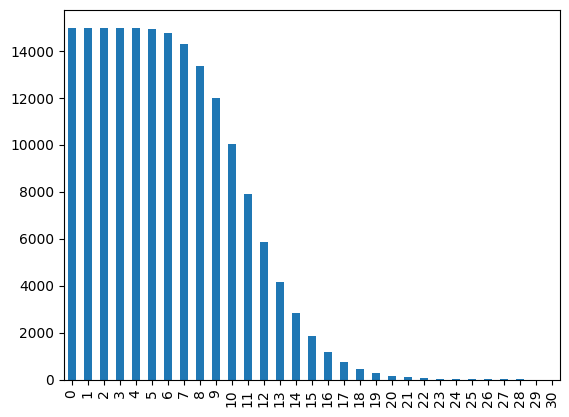

In [18]:
train_data_df['pos'].value_counts().plot.bar()

In [19]:
# Most sentences have less than 20 words, hence this will be our depth in one_hot method
position_labels_train = tf.one_hot(train_data_df['pos'], depth = 20)
position_labels_test = tf.one_hot(test_data_df['pos'], depth = 20)
position_labels_validation = tf.one_hot(validation_data_df['pos'], depth = 20)

In [20]:
# We will also include information about sentence length. We set the same depth
num_lines_labels_train = tf.one_hot(train_data_df['num_lines'], depth = 20)
num_lines_labels_test = tf.one_hot(test_data_df['num_lines'], depth = 20)
num_lines_labels_validation = tf.one_hot(validation_data_df['num_lines'], depth = 20)

## Build model

In [21]:
#### Create 4 input layers for all information model will get
word_input = tf.keras.layers.Input(shape = (1,), dtype = 'string', name = 'word_input') # input is one string
char_input = tf.keras.layers.Input(shape = (1,), dtype = 'string', name = 'char_input') # input is one string
position_input = tf.keras.layers.Input(shape = (20, ), name = 'position_input') # one-hot encoding of position has dim 20
num_lines_input = tf.keras.layers.Input(shape = (20, ), name = 'num_lines_input')

#### Word input is going though vectorizer, word embedding layer, bidirectional LSTM
word_output = text_vectorizer_words(word_input)
word_output = word_embed(word_output)
word_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 32))(word_output)

### Char input is going through vectorizer, char embeddding layer, bidirectional LSTM
char_output = text_vectorizer_chars(char_input)
char_output = char_embed(char_output)
char_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 32))(char_output)

### Sentence positions go through Dense layer
position_output = tf.keras.layers.Dense(units = 32, activation = 'relu', kernel_initializer = 'he_normal')(position_input)

### Line number info goes through Dense layer
num_lines_output = tf.keras.layers.Dense(units = 32, activation = 'relu', kernel_initializer = 'he_normal')(num_lines_input)

### Combine word and char outputs, pass them through Dense layer and add Dropout for regularization
word_and_char_output_combined = tf.keras.layers.Concatenate()([word_output, char_output])
word_and_char_output_combined = tf.keras.layers.Dense(units = 256, activation = 'relu', kernel_initializer = 'he_normal')(word_and_char_output_combined)
word_and_char_output_combined = tf.keras.layers.Dropout(rate = 0.5)(word_and_char_output_combined)

### Concatenate all outputs and pass them through output layer
all_outputs_combined = tf.keras.layers.Concatenate()([position_output,
                                                      num_lines_output,
                                                      word_and_char_output_combined])
output = tf.keras.layers.Dense(units = 5, activation = 'softmax')(all_outputs_combined)

### Create and compile model
model = tf.keras.models.Model(inputs = [word_input,
                                        char_input,
                                        position_input,
                                        num_lines_input],
                              outputs = output)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#### Show model's architecture

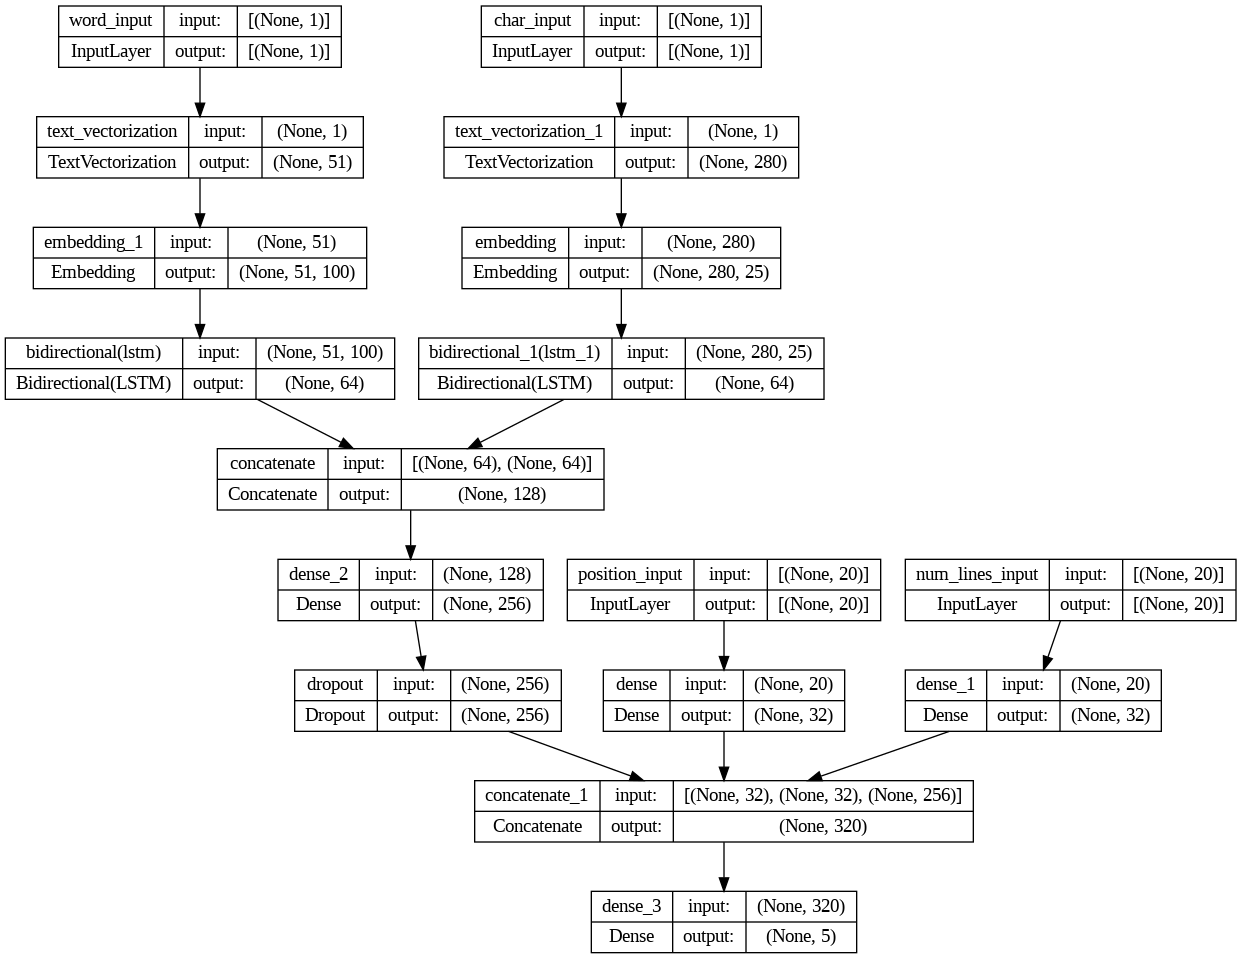

In [22]:
plot_model(model, show_shapes = True)

## Train model

In [23]:
#### Collect all input variables for training
train_sentences = train_data_df['text'].to_numpy()
position_labels_train = position_labels_train
num_lines_labels_train = num_lines_labels_train
train_labels_one_hot = train_labels_one_hot

#### Collect all input variables for validation
validation_sentences = validation_data_df['text'].to_numpy()
position_labels_validation = position_labels_validation
num_lines_labels_validation = num_lines_labels_validation
validation_labels_one_hot = validation_labels_one_hot


In [24]:
history = model.fit(x = [train_sentences,
               train_sentences,
               position_labels_train,
               num_lines_labels_train],
          y = train_labels_one_hot,
          batch_size = 32,
          epochs = 5,
          validation_data = ([validation_sentences,
                              validation_sentences,
                              position_labels_validation,
                              num_lines_labels_validation], validation_labels_one_hot))

Epoch 1/5
5627/5627 [==============================] - 199s 33ms/step - loss: 0.4561 - accuracy: 0.8278 - val_loss: 0.3510 - val_accuracy: 0.8661
Epoch 2/5
5627/5627 [==============================] - 187s 33ms/step - loss: 0.3438 - accuracy: 0.8725 - val_loss: 0.3199 - val_accuracy: 0.8814
Epoch 3/5
5627/5627 [==============================] - 206s 37ms/step - loss: 0.3211 - accuracy: 0.8812 - val_loss: 0.3069 - val_accuracy: 0.8855
Epoch 4/5
5627/5627 [==============================] - 179s 32ms/step - loss: 0.3065 - accuracy: 0.8872 - val_loss: 0.3046 - val_accuracy: 0.8861
Epoch 5/5
5627/5627 [==============================] - 186s 33ms/step - loss: 0.2959 - accuracy: 0.8915 - val_loss: 0.2986 - val_accuracy: 0.8887


### The accuracy is around 89%. There is still room for improvement as the model clearly is not overfitting yet.